In [2]:
import pickle
import pandas as pd
import numpy as np
from imp import reload
import math
import h5py
import shutil
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Subset
from itertools import chain
from sklearn.model_selection import KFold
from progiter import ProgIter
from sklearn.model_selection import train_test_split
from mymodule import Trasnformer_model, VAE_model
from rdkit.Chem import MolFromSmiles, Draw
from rdkit.Chem.Draw import IPythonConsole
from collections import defaultdict

random_state=34
IPythonConsole.ipython_useSVG=True


In [3]:
# all drugs
with open('/tf/notebooks/code_for_pub/smiles_files/smiles_drugcombANDchembl26.pickle','rb') as f:
    a = pickle.load(f)
with open('/tf/notebooks/code_for_pub/smiles_files/smiles_drugcomb_BY_cid_duplicated.pickle','rb') as f:
    b = pickle.load(f)
smiles = a.append(b).drop_duplicates().reset_index(drop=True)
v = Trasnformer_model.WordVocab(smiles, max_size=None, min_freq=1)
#dataset = Trasnformer_model.Seq2seqDataset(smiles, v, seq_len=145)


Building Vocab


In [4]:
dir(v)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'eos_index',
 'extend',
 'freqs',
 'from_seq',
 'itos',
 'load_vocab',
 'mask_index',
 'pad_index',
 'save_vocab',
 'sos_index',
 'stoi',
 'to_seq',
 'unk_index',
 'vectors',
 'vocab_rerank']

### 64 bit

In [15]:
model = Trasnformer_model.TrfmSeq2seq(
    in_size=len(v), 
    hidden_size = 16,
    out_size=len(v),
    n_layers=6
)
m = torch.load('/tf/notebooks/code_for_pub/_logs_as_python_files/transformer_training_logs/T16_model_best.pth.tar')
model.load_state_dict(m['state_dict'])
model.eval()

In [75]:
dataset = Trasnformer_model.Seq2seqDataset(b.values, v, seq_len=145)
to_encode = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

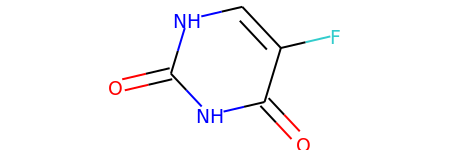

In [134]:
# just checking. This should be 5-FU

molecule = MolFromSmiles(''.join(v.from_seq(dataset[0]))[5:28])
molecule

In [154]:
fp_transformer_64 = np.zeros((len(dataset), 64+1), dtype=np.float)

with torch.no_grad():
    for cid,(ind, sm) in ProgIter(zip(b.index,enumerate(to_encode)), total=len(dataset)):
        fp_transformer_64[ind]= np.hstack((np.array(cid) , model.encode(torch.t(sm)).reshape(-1)))

df_fp_transformer_64 = pd.DataFrame(data=fp_transformer_64)



 4153/4153... rate=134.49 Hz, eta=0:00:00, total=0:00:30, wall=01:23 UTC


In [155]:
drugs_name = '/tf/notebooks/code_for_pub/smiles_files/drugcomb_drugs_export_OCT2020.csv'
drugs = pd.read_csv(drugs_name, names=['dname','id', 'smiles', 'cid'], header=0) # oct2020 version

mapping = defaultdict(list) 
for i in drugs.itertuples(): # map cid to id
    mapping[i.cid] = i.id
    
df_fp_transformer_64.iloc[:,0] = df_fp_transformer_64.iloc[:,0].astype(int)
df_fp_transformer_64.rename(columns={0:'cid'}, inplace=True)
df_fp_transformer_64['cid'] = df_fp_transformer_64['cid'].map(mapping)
df_fp_transformer_64.rename(columns={'cid':'id'}, inplace=True)
df_fp_transformer_64.set_index(keys='id', drop=True, inplace=True)

In [179]:
df_fp_transformer_64.head()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
id,,,,,,,,,,,,,,,,,,,,,
1,-0.017833,-0.066369,-0.028680,0.216570,0.051967,-0.051174,-0.005353,0.112651,-0.001576,0.078064,...,-0.822641,-3.049594,-0.407887,0.480870,-0.442266,0.196142,0.955286,-0.261621,0.583369,1.301811
2,-0.020109,-0.057423,-0.016948,0.157078,0.055972,-0.049414,0.000251,0.106124,0.004925,0.083084,...,-0.825921,-3.074596,-0.405278,0.472952,-0.444017,0.196169,0.975859,-0.217412,0.597471,1.256750
3,-0.027824,-0.032918,0.011989,-0.007332,0.066567,-0.044038,0.020478,0.084508,0.022263,0.102263,...,-0.827926,-3.067765,-0.417167,0.500369,-0.448673,0.187110,0.981258,-0.177586,0.594257,1.238373
4,-0.027769,-0.032945,0.011906,-0.007347,0.066575,-0.044028,0.020586,0.084441,0.022224,0.102299,...,-0.826173,-3.065923,-0.417958,0.500914,-0.448405,0.185515,0.979248,-0.181459,0.593378,1.243197
5,-0.023623,-0.047175,-0.004586,0.088406,0.060553,-0.047217,0.007928,0.097785,0.012289,0.090474,...,-0.827924,-3.077395,-0.406876,0.484428,-0.444813,0.196352,0.978595,-0.197761,0.594403,1.245485


In [157]:

with open('/tf/notebooks/code_for_pub/fp_files/fps_transformer_64bit_new.pickle','wb') as f:
    pickle.dump(df_fp_transformer_64,f)

### 1024 bit

In [160]:
model = Trasnformer_model.TrfmSeq2seq(
    in_size=len(v), 
    hidden_size = 256,
    out_size=len(v),
    n_layers=6
)
m = torch.load('/tf/notebooks/code_for_pub/_logs_as_python_files/transformer_training_logs/T256_model_best.pth.tar')
model.load_state_dict(m['state_dict'])
model.eval()

TrfmSeq2seq(
  (embed): Embedding(58, 256)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (trfm): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, 

In [167]:
dataset = Trasnformer_model.Seq2seqDataset(b.values, v, seq_len=145)
to_encode = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

In [168]:
fp_transformer_1024 = np.zeros((len(dataset), 1024+1), dtype=np.float)

with torch.no_grad():
    for cid, (ind, sm) in ProgIter(zip(b.index,enumerate(to_encode)), total=len(dataset)):
        fp_transformer_1024[ind]= np.hstack((np.array(cid) , model.encode(torch.t(sm)).reshape(-1)))

fp_transformer_1024 = pd.DataFrame(data=fp_transformer_1024)



 4153/4153... rate=75.70 Hz, eta=0:00:00, total=0:00:54, wall=20:54 UTC


In [170]:
drugs_name = '/tf/notebooks/code_for_pub/smiles_files/drugcomb_drugs_export_OCT2020.csv'
drugs = pd.read_csv(drugs_name, names=['dname','id', 'smiles', 'cid'], header=0) # oct2020 version

mapping = defaultdict(list) 
for i in drugs.itertuples(): # map cid to id
    mapping[i.cid] = i.id
    
fp_transformer_1024.iloc[:,0] = fp_transformer_1024.iloc[:,0].astype(int)
fp_transformer_1024.rename(columns={0:'cid'}, inplace=True)
fp_transformer_1024['cid'] = fp_transformer_1024['cid'].map(mapping)
fp_transformer_1024.rename(columns={'cid':'id'}, inplace=True)
fp_transformer_1024.set_index(keys='id', drop=True, inplace=True)

In [178]:
fp_transformer_1024.head()

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
id,,,,,,,,,,,,,,,,,,,,,
1,0.163175,0.583282,0.408211,0.067850,-0.215724,-0.103014,-1.134651,-0.112591,-2.348408,-0.510069,...,-1.431290,0.019932,0.055007,0.849483,0.135861,1.088838,-0.133459,0.074664,0.730141,0.339768
2,0.163178,0.583281,0.408218,0.067851,-0.215724,-0.103012,-1.134651,-0.112591,-2.348407,-0.510074,...,-1.431298,0.019901,0.054955,0.849428,0.135838,1.088819,-0.133430,0.074673,0.730105,0.339737
3,0.163181,0.583273,0.408231,0.067855,-0.215724,-0.103016,-1.134644,-0.112585,-2.348398,-0.510084,...,-1.431322,0.019832,0.054881,0.849362,0.135798,1.088803,-0.133403,0.074649,0.730104,0.339685
4,0.163183,0.583273,0.408235,0.067855,-0.215726,-0.103012,-1.134644,-0.112585,-2.348397,-0.510086,...,-1.431303,0.019823,0.054865,0.849344,0.135798,1.088794,-0.133415,0.074659,0.730094,0.339680
5,0.163183,0.583280,0.408225,0.067854,-0.215721,-0.103017,-1.134645,-0.112586,-2.348397,-0.510080,...,-1.431323,0.019864,0.054910,0.849379,0.135814,1.088787,-0.133418,0.074691,0.730089,0.339706


In [175]:

with open('/tf/notebooks/code_for_pub/fp_files/fps_transformer_1024bit_new.pickle','wb') as f:
    pickle.dump(fp_transformer_1024,f)